In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd

In [22]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [24]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model using automap_base()

Base = automap_base()

# reflect the tables with Base.prepare(), passing in the engine and reflect=True
Base.prepare(engine, reflect=True)


In [26]:
# We can view all of the classes that automap found with Base.classes
Base.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [28]:
# Create our Session() and bind it to the engine
session = Session(bind=engine)

In [29]:
inspector = inspect(engine)
measurement_insp = inspector.get_columns('measurement')
pd.DataFrame(measurement_insp)

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0


# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data

In [30]:
# Calculate the date 1 year ago from the last data point in the database
# Use the datetime.timedelta() function to help calculating the difference of one year, 12 months, or 365 days
last_date = (session
    .query(Measurement.date)
    .order_by(Measurement.date.desc())
    .first().date)
last_date 

'2017-08-23'

In [31]:
# Use the datetime.timedelta() function to help calculating the difference of one year, 12 months, or 365 days
One_Year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') -dt.timedelta(days=365)
One_Year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [32]:
# Use session.query() to retrieve the date and prcp columns, .filter() by the date you calculated above, and selecting .all() results

rain_past_year = (session
    .query(Measurement.date, func.avg(Measurement.prcp))
    .filter(Measurement.date >= One_Year_ago)
    .group_by(Measurement.date).all())
rain_past_year

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 

In [33]:
# Save the query results as a Pandas DataFrame() and set the index to the date column
rain_past_year_df = pd.DataFrame(rain_past_year[:10], columns=['Date', 'Precipitation'])
rain_past_year_df.set_index('Date', inplace=True, )
rain_past_year_df

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
2016-08-29,0.243333
2016-08-30,0.011667
2016-08-31,0.636000
2016-09-01,0.006000


In [34]:
# Sort the dataframe by date
rain_past_year_df = rain_past_year_df.sort_values(by='Date', ascending=True)
rain_past_year_df


#Use Pandas Plotting with Matplotlib to plot the data
#rain_past_year_df.plot(rot=90)
#plt.xlabel("Date")
#plt.ylabel("Inches")


,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
2016-08-29,0.243333
2016-08-30,0.011667
2016-08-31,0.636000
2016-09-01,0.006000


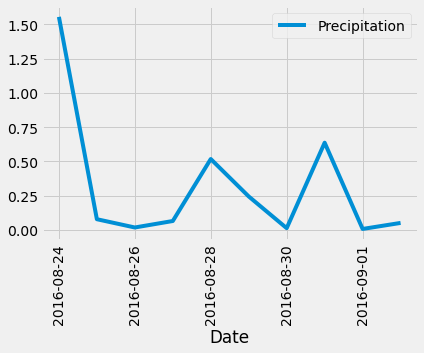

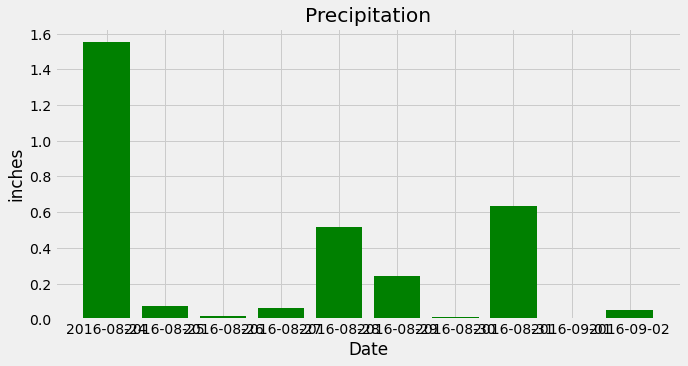

In [35]:
rain_past_year_df.plot(rot=90)
plt.figure(figsize=(10,5))
plt.bar(rain_past_year_df.index, rain_past_year_df['Precipitation'],color='green')
plt.title("Precipitation")
plt.ylabel("inches")
plt.xlabel("Date")
plt.savefig("Images/Precipitation.png")
plt.show()

In [36]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_past_year_df.describe()

,Precipitation
count,10.000000
mean,0.317648
std,0.489066
min,0.006000
25%,0.025000
50%,0.070571
75%,0.448333
max,1.555000


##### Design a query to show how many stations are available in this dataset


In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order. Hint: session.query() the station column in the Station table
(session
 .query(Measurement.station, func.count(Measurement.prcp))
 .group_by(Measurement.station)
 .order_by(func.count(Measurement.prcp).desc())
 .all())


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order. Hint: session.query() the station column in the Station table
(session
 .query(Measurement.station, Station.name)
 .join(Station, Measurement.station == Station.station)
 .all())


[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, H

In [48]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station

# The most active station from prior query is USC00519281.

(session
 .query(Measurement.station,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs))
 .filter(Measurement.station =='USC00519281')
 .all())

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temp_last_12m = []
for rain in [1, 2, 3]:
    Temp_last_12m += list(session
                     .query(Measurement.date, Measurement.station, Measurement.tobs)
                     .filter(Measurement.station == 'USC00519281')
                     .filter(Measurement.date >= One_Year_ago)
                     .all())
Temp_last_12m_df = pd.DataFrame(Temp_last_12m).set_index('date')

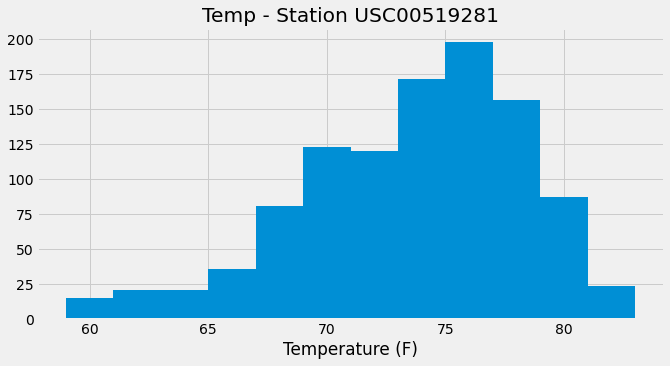

In [67]:
plt.figure(figsize=(10,5))
plt.xlabel("Temperature (F)")
plt.title("Temp - Station USC00519281")
plt.hist(Temp_last_12m_df['tobs'],bins=12)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return (session.query(func.min(Measurement.tobs), 
                         func.avg(Measurement.tobs), 
                         func.max(Measurement.tobs))
                    .filter(Measurement.date >= start_date)
                    .filter(Measurement.date <= end_date)
                    .all())

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    return (session.query(func.min(Measurement.tobs), 
                          func.avg(Measurement.tobs), 
                          func.max(Measurement.tobs))
                   .filter(func.strftime("%m-%d", Measurement.date) == date)
                   .all())
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
